# RoBERTa Classifier with IMSLP LM pretraining & finetuning

In this notebook we will train a RoBERTa classifier for the proxy task using the language model trained on IMSLP and finetuned on target data for initialization.  The language model is trained in 04_roberta_lm.ipynb.

This notebook is adapted from [this](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2) blog post.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.text import *
from transformers import RobertaForSequenceClassification, RobertaConfig
import eval_models
from train_utils import *

/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dyang/anaconda3/envs/test_env/lib/pyt

In [3]:
import fastai
import transformers
import tokenizers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print('tokenizers version :', tokenizers.__version__)

fastai version : 1.0.61
transformers version : 2.4.1
tokenizers version : 0.4.2


In [4]:
torch.cuda.set_device(1)

### Prep databunch

In [5]:
bs = 64
seed = 42
tok_model_dir = '/home/dyang/InstrumentID/tokenizer/roberta_tok/shift0'
max_seq_len = 256

In [6]:
cust_tok = CustomTokenizer(TransformersBaseTokenizer, tok_model_dir, max_seq_len)
transformer_base_tokenizer = TransformersBaseTokenizer(tok_model_dir, max_seq_len)
transformer_vocab =  TransformersVocab(tokenizer = transformer_base_tokenizer._pretrained_tokenizer)

In [7]:
pad_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('<pad>')

In [8]:
bpe_path = Path('/home/dyang/InstrumentID/train_data')
train_df = pd.read_csv(bpe_path/'train_df-frag64.char.csv')
valid_df = pd.read_csv(bpe_path/'valid_df-frag64.char.csv')
test_df = pd.read_csv(bpe_path/'test_df-frag64.char.csv')

In [9]:
valid_df

,label,text
0,flute,一一一一一一一一 丈一一一一一一一 亀一一一一一一一 一丄一一一一一一 一亀一一一一一一 一...
1,flute,丁一一一一一一一 丂一一一一一一一 丈一一一一一一一 丐一一一一一一一 乀一一一一一一一 亀...
2,flute,丁一一一一一一一 丄一一一一一一一 丈一一一一一一一 丠一一一一一一一 乀一一一一一一一 亀...
3,flute,丂一一一一一一一 丂一一一一一一一 丁一一一一一一一 丁一一一一一一一 丂一一一一一一一 丂...
4,flute,丂一一一一一一一 丄一一一一一一一 一丄一一一一一一 一丈一一一一一一 丈一一一一一一一 丐...
...,...,...
9595,cello,一一丂丁一一一一 一乀丠一一一一一 一亀乀一一一一一 一乀丠一一一一一 一亀乀一一一一一 一...
9596,cello,一丂一丂一一一一 一丂一丂一一一一 一丁一一一一一一 一一一丈一一一一 一一一丈一一一一 一...
9597,cello,一一丄丂一一一一 一一亁一一一一一 一一丂一一一一一 一一乂一一一一一 一一乐一一一一一 一...
9598,cello,一一一丆一一一一 一一一丌一一一一 一一一丸一一一一 丁一一习一一一一 一丠丄一一一一一 一...


In [10]:
train_df

,label,text
0,clarinet,一一一一一一一一 一一一一一一一一 一一一丐一一一一 一一一丐一一一一 一一一丈一一一一 一...
1,clarinet,一一一一一一一一 乀丁一一一一一一 亀一一一一一一一 一丐一一一一一一 一亐两三一一一一 一...
2,clarinet,丁一一一一一一一 丌一一一一一一一 一丠一一一一一一 一一丂一一一一一 一一一一一一一一 丈...
3,clarinet,丁一一一一一一一 一乀両一一一一一 一丐丁一一一一一 丐一一一一一一一 丐一丈一一一一一 一...
4,clarinet,丂一一一一一一一 丂一一一一一一一 丂一一一一一一一 丂一一一一一一一 丄一一一一一一一 丐...
...,...,...
28795,trumpet,一一亀丈一一一一 一一亀丈一一一一 一一亀丈一一一一 一一亀丈一一一一 一一亀丈一一一一 一...
28796,trumpet,一一一丐一一一一 一一一丈一一一一 一一一丈一一一一 一一一丁一一一一 一一一丂一一一一 一...
28797,trumpet,丂一一丐一一一一 一乀一一一一一一 一丠一一一一一一 一丐一一一一一一 一丈一一一一一一 一...
28798,trumpet,三一一丠一一一一 丠一一一一一一一 丂一一一一一一一 丠一一一一一一一 一亠乀一一一一一 一...


In [11]:
data_clas = TextDataBunch.from_df(bpe_path, train_df, valid_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


### Train Classifier

In [12]:
model_class, config_class = RobertaForSequenceClassification, RobertaConfig
model_path = '/home/dyang/InstrumentID/roBERTa_train_lm-all-shift0/'

In [13]:
config = config_class.from_pretrained(model_path)
config.num_labels = data_clas.c

In [14]:
transformer_model = model_class.from_pretrained(model_path, config = config)
custom_transformer_model = RobertaModelWrapper(transformer_model, pad_idx)

In [15]:
# learner.destroy()
# torch.cuda.empty_cache()

In [16]:
learner = Learner(data_clas, custom_transformer_model, metrics=[accuracy, FBeta(average='macro', beta=1)])

In [17]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.pooler]

In [18]:
learner.split(list_layers)
print(learner.layer_groups)

[Sequential(
  (0): Embedding(11805, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, o

In [19]:
seed_all(seed)

In [20]:
learner.freeze_to(-1)

In [21]:
#learner.summary()

In [22]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-04
Min loss divided by 10: 7.59E-04


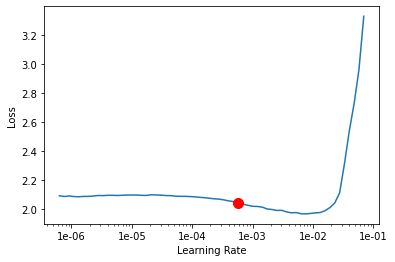

In [31]:
learner.recorder.plot(suggestion=True)

In [56]:
lr = 7.59E-04

In [57]:
learner.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.593300,1.817324,0.349583,0.329291,00:46
1,1.540517,1.743828,0.366771,0.362604,00:47
2,1.458501,1.720850,0.394271,0.386691,00:47
3,1.384683,1.769572,0.370417,0.362423,00:47
4,1.294806,1.738475,0.390417,0.385363,00:47
5,1.245717,1.781770,0.389375,0.380953,00:47


KeyboardInterrupt: 

In [51]:
learner.freeze_to(-1)
learner.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.135106,1.737177,0.394583,0.395374,00:48


In [34]:
learner.freeze_to(-2)
learner.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.212209,1.819142,0.382500,0.380926,00:57
1,0.887041,1.890206,0.403125,0.398509,00:57


In [35]:
learner.freeze_to(-3)
learner.fit_one_cycle(3, slice(lr/2/(2.6**4),lr/2), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.882469,2.038010,0.388229,0.383757,01:07
1,0.649292,2.224070,0.400104,0.391599,01:07
2,0.368649,2.422941,0.399479,0.394671,01:07


In [58]:
learner.unfreeze()
learner.fit_one_cycle(1, lr)

In [23]:
#learner.save('roberta_train-imslp_finetune-target_clas1')
learner.load('roberta_train-imslp_finetune-target_clas1')

Learner(data=TextClasDataBunch;

Train: LabelList (28800 items)
x: TextList
<s> 一一一一一一一一</w> 一一一一一一一一</w> 一一一丐一一一一</w> 一一一丐一一一一</w> 一一一丈一一一一</w> 一一一一一一一一</w> 一一一丈一一一一</w> 一一一丐一一一一</w> 一一一丠一一一一</w> 一一一丠一一一一</w> 一一一丠一一一一</w> 一一一丈一一一一</w> 一一一丐一一一一</w> 一一一丈一一一一</w> 一一一丄一一一一</w> 一一一丂一一一一</w> 一一一丄一一一一</w> 一一一丠一一一一</w> 一一一丠一一一一</w> 一一一丄一一一一</w> 一一一丁一一一一</w> 一一一丂一一一一</w> 一一一丄一一一一</w> 一一一丂一一一一</w> 一一一丈一一一一</w> 一一一丂一一一一</w> 一一一丁一一一一</w> 一一亀一一一一一</w> 一一一丂一一一一</w> 一一一丄一一一一</w> 一一一丐一一一一</w> 一一一丠一一一一</w> 一一一乀一一一一</w> 一一乀丠一一一一</w> 一一一乀一一一一</w> 一一一丐一一一一</w> 一一一丄一一一一</w> 一一一丐一一一一</w> 一一一丠一一一一</w> 一一一丐一一一一</w> 一一一丈一一一一</w> 一一一丄一一一一</w> 一一一丈一一一一</w> 一一一丁一一一一</w> 一一一丂一一一一</w> 一一一丄一一一一</w> 一一一丁一一一一</w> 丁一一一一一一一</w> 丄一一一一一一一</w> 丂一一一一一一一</w> 丐一一一一一一一</w> 丄一一一一一一一</w> 丐一一一一一一一</w> 一一一丒一一一一</w> 一一一丂一一一一</w> 么一一一一一一一</w> 一一一三一一一一</w> 一一一三一一一一</w> 一且一一一一一一</w> 一仁一一一一一一</w> 一一一丁一一一一</w> 一一亀一一一一一</w> 一一一丄一一一一</w> 一一一丁一一一一</w> </s>,<s> 一一一一一一一一</w> 乀丁一一一一一一</w> 亀一一一一一一一</w> 一丐一一一一一一</w> 一亐 两 三一一一一</w> 一丐一一一一一一</w>

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [61]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_df, test_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

In [62]:
learner.validate(data_clas_test.valid_dl)

[2.162744,
 tensor(0.4320),
 tensor(0.3548),
 tensor(0.3589),
 tensor(0.4430),
 tensor(0.8276),
 tensor(0.2885),
 tensor(0.3616),
 tensor(0.4564),
 tensor(0.3527)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [40]:
train_fullpage_df = pd.read_csv(bpe_path/'fullpage_train.char.csv')
valid_fullpage_df = pd.read_csv(bpe_path/'fullpage_valid.char.csv')
test_fullpage_df = pd.read_csv(bpe_path/'fullpage_test.char.csv')

In [41]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df,
                                       tokenizer=cust_tok, vocab=transformer_vocab, include_bos=False, 
                                       include_eos=False, pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [42]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df, databunch=data_clas_test)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.5649773478507996, 0.6151589155197144),
 (0.44631895189862847, 0.4716551642208188))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [69]:
test_ensemble_df = pd.read_csv(bpe_path/'test.ensemble64.char.csv')

FileNotFoundError: [Errno 2] File /home/dyang/InstrumentID/train_data/test.ensemble64.char.csv does not exist: '/home/dyang/InstrumentID/train_data/test.ensemble64.char.csv'

In [ ]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df,
                                       text_cols = 'text', label_cols = 'label', tokenizer=cust_tok, 
                                       vocab=transformer_vocab, include_bos=False, include_eos=False, 
                                       pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [ ]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, databunch=data_clas_test, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

### Error Analysis

In [23]:
interp = ClassificationInterpretation.from_learner(learner)

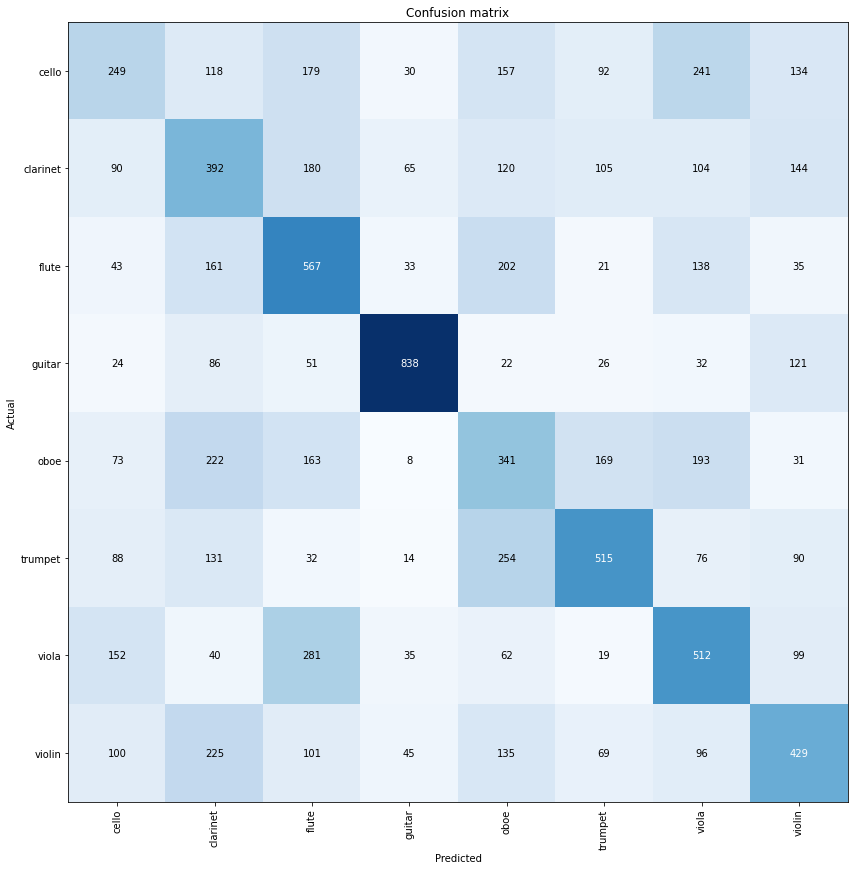

In [71]:
interp.plot_confusion_matrix(figsize=(12,12))

In [25]:
def convertLineToCharSeq(line):
    ints = [int(p) for p in line.split()]
    result = ' '.join([int2charseq(i) for i in ints])
    return result
def int2charseq(int64):
    chars = ''
    for i in range(8):
        numshift = i * 8
        charidx = (int64 >> numshift) & 255
        chars += chr(19968 + charidx) # 19968 ensures that all chars are chinese characters (not newline, space, etc)
    result = ''.join(chars)
    #print(int64,result)
    return result

In [26]:
def char_to_int(s):
    s.strip()
    data = s.split(' ')
    bscore = []
    for i in data:
        num = 0
        mult = 1
        for c in i:
            tmp = ord(c)-19968
            tmp*=mult
            num+=tmp
            mult*=256
        bscore.append(num)
    return bscore

In [27]:
def shift(query, shift_factor):
    bscore = char_to_int(query)
    rows = ['']*(2*shift_factor+1)
    for inte in bscore:
        for i in range(shift_factor+1):
            if i==0:
                rows[i]+=str(inte)+" "
            else:
                rows[i]+= str((inte >> i)% 2**31)+" "
                rows[-i]+=str((inte << i) % 2**31)+" "
    for idx in range(len(rows)):
        rows[idx] = convertLineToCharSeq(rows[idx].strip())
    return rows

In [28]:
# ? total queries
from fastai.callbacks.hooks import *
import tqdm
instruments = ['cello','clarinet','flute','guitar','oboe','trumpet','viola','violin']
points = []
labels = []
acc = []
test_df1 = test_df.sample(frac=1)
for index, row in tqdm.tqdm(test_df1.iterrows()):
    original = row['text']
    shifted = shift(original,0)
    predictions = np.zeros(8)
    activations = np.zeros(768)
    for query in shifted:
        nn_module = list(learner.model.modules())[-1]
        nn_module1 = list(learner.model.modules())[-2]
        hook = hook_output(nn_module)
        hook1 = hook_output(nn_module1)
        
        learner.predict(query)
        probability = hook.stored.cpu().detach().numpy()[0]
        predictions+=probability
        hook.remove
        
        activations+=hook1.stored.cpu().detach().numpy()[0]
        hook1.remove
        
    predictions = predictions/len(shifted)
    activations = activations/len(shifted)
    points.append(activations)
    labels.append(instruments[np.argmax(predictions)])
    if row['label'] == instruments[np.argmax(predictions)]:
        acc.append(1)
    else:
        acc.append(0)
    if index%1000==0:
        print(np.average(acc))
print(np.average(acc))

1633it [04:06,  7.21it/s]

0.44056372549019607


1750it [04:24,  5.87it/s]

0.44082332761578047


3704it [09:31,  5.25it/s]

0.43208209559816363


4848it [12:36,  6.57it/s]

0.4270682896637095


7034it [18:39,  5.85it/s]

0.4315370396701265


7408it [19:43,  5.74it/s]

0.43188875388146347


7468it [19:54,  5.75it/s]

0.4327038971474488


8633it [23:22,  5.47it/s]

0.4307228915662651


8844it [24:02,  5.37it/s]

0.43084925930114215


9042it [24:39,  5.39it/s]

0.4303727463776131


9600it [26:26,  6.05it/s]

0.4319791666666667


In [29]:
# 0 42.19
# 1 43.02
# 2 
# 3 38.5
# 4 
# 5 

In [30]:
def plot_tSNE(x, y):
    num_classes = len(np.unique(y))
    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj = tsne.fit_transform(x)
    tsne_df = pd.DataFrame({'X': tsne_obj[:, 0],
                           'Y': tsne_obj[:, 1],
                           'composer': y})
    plt.figure(figsize=(16, 10))
    legend_position = "right"
    return (ggplot(tsne_df, aes(x="X", y="Y")) + 
        geom_point(aes(color = 'factor(composer)'), alpha=0.8) +
        theme_bw() +
        guides(colour = guide_legend(override_aes = {'alpha': 1})) +
        theme(dpi=300, legend_title=element_blank(), legend_key=element_blank(), 
            axis_text_x = element_blank(),
            axis_text_y = element_blank(),
            axis_title_x = element_blank(),
            axis_title_y = element_blank(),
            axis_ticks = element_blank()))

<Figure size 1152x720 with 0 Axes>

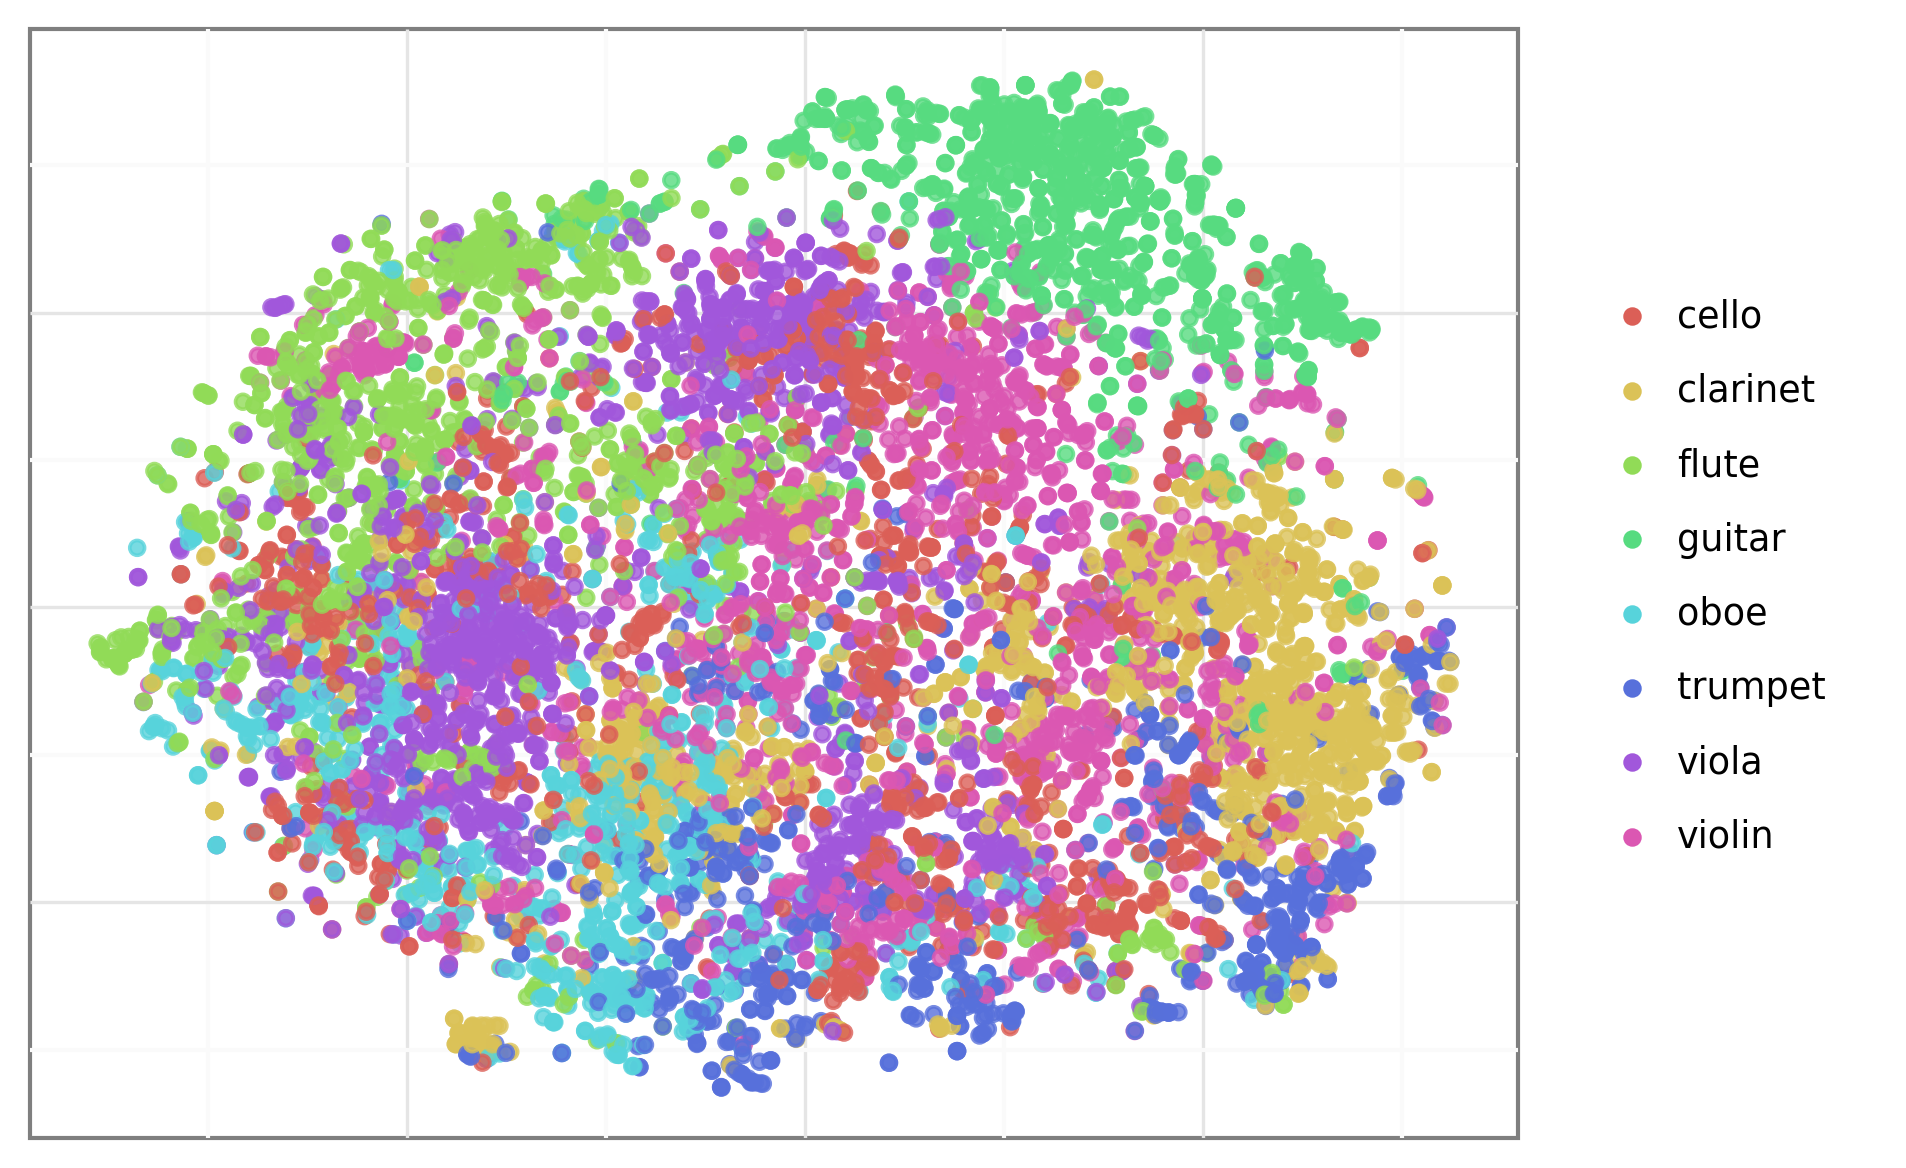

<ggplot: (-9223363289517988797)>

In [31]:
from sklearn.manifold import TSNE
from plotnine import *
plot_tSNE(points, labels)

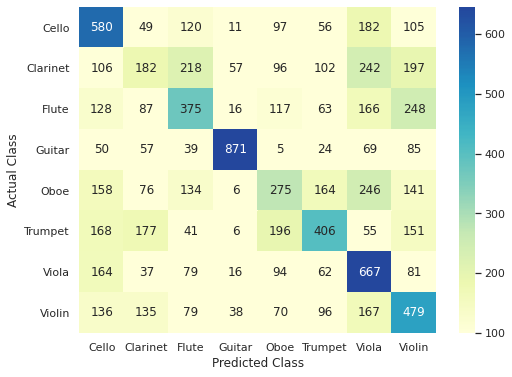

In [26]:
import seaborn as sns
interp = ClassificationInterpretation.from_learner(learner)
mat = interp.confusion_matrix()
midpoint = (np.amax(mat) - np.amin(mat)) // 2
sns.set(font_scale=1)
plt.figure(figsize=(8, 6))
# also run the code below for cmap = 'BuPu', 'OrRd', 'YlGnBu_r'
h = sns.heatmap(mat, 
            annot=True, 
            fmt="d", 
            cmap='YlGnBu', 
            center=midpoint, 
            vmin=100, 
            robust=True,
# uncomment to show cell borders - will have to run this code with borders/no borders because he wants to see both
#             linewidths=1, linecolor='black',
            square=False)
plt.yticks(rotation=0) 
h.set_xticklabels(['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin'])
h.set_yticklabels(['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin'])
h.set(xlabel="Predicted Class", ylabel="Actual Class")
plt.savefig('confusion_matrix.png', dpi=300)

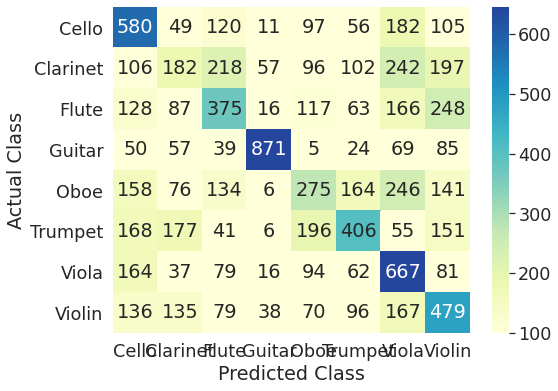

In [30]:
import seaborn as sns
interp = ClassificationInterpretation.from_learner(learner)
mat = interp.confusion_matrix()
midpoint = (np.amax(mat) - np.amin(mat)) // 2
sns.set(font_scale=1.6)
plt.figure(figsize=(8, 6))
# also run the code below for cmap = 'BuPu', 'OrRd', 'YlGnBu_r'
h = sns.heatmap(mat, 
            annot=True, 
            fmt="d", 
            cmap='YlGnBu', 
            center=midpoint, 
            vmin=100, 
            robust=True,
# uncomment to show cell borders - will have to run this code with borders/no borders because he wants to see both
#             linewidths=1, linecolor='black',
            square=False)
plt.yticks(rotation=0) 
h.set_xticklabels(['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin'])
h.set(xlabel="Predicted Class", ylabel="Actual Class")
plt.savefig('confusion_matrix.png', dpi=300)

In [51]:
for fname in os.listdir("/home/dyang/InstrumentID/bootleg_data-v1/all/guitar/"):
    fname = "guitar_1462.bscore"
    name = os.path.join("/home/dyang/InstrumentID/bootleg_data-v1/all/guitar/",fname)
    with open(name,'rb') as f:
        data = pickle.load(f)
        for idx,page in enumerate(data):
            pred_string = ""
            for count,i in enumerate(page):
                pred_string+=str(i)+ ' '
                if count == 63:
                    break
            i1 = convertLineToCharSeq(pred_string)
            pred_string.strip()
            if str(learner.predict(i1)[0]) == "guitar":
                #print(fname,idx+1)
                #print(learner.predict(i1)[2])
                continue
            else:
                #if learner.predict(i1)[2][2] > 0.95:
                print(fname,idx+1)
                print(learner.predict(i1)[2])
                #print(fname,idx+1)
                continue
                
#i = ['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin']

cello_78.bscore 1
tensor([6.2899e-06, 5.2807e-01, 1.8988e-01, 4.1750e-02, 1.8908e-01, 4.4705e-02,
        2.3946e-03, 4.1071e-03])
cello_78.bscore 2
tensor([5.9648e-04, 8.7767e-01, 3.0743e-03, 1.2777e-02, 1.2363e-03, 3.7155e-04,
        7.8621e-03, 9.6417e-02])
cello_78.bscore 3
tensor([6.2899e-06, 5.2807e-01, 1.8988e-01, 4.1750e-02, 1.8908e-01, 4.4705e-02,
        2.3946e-03, 4.1071e-03])
cello_78.bscore 4
tensor([6.2899e-06, 5.2807e-01, 1.8988e-01, 4.1750e-02, 1.8908e-01, 4.4705e-02,
        2.3946e-03, 4.1071e-03])
cello_78.bscore 5
tensor([6.2899e-06, 5.2807e-01, 1.8988e-01, 4.1750e-02, 1.8908e-01, 4.4705e-02,
        2.3946e-03, 4.1071e-03])
cello_78.bscore 6
tensor([0.3536, 0.0040, 0.2429, 0.1754, 0.0165, 0.0042, 0.1358, 0.0677])
cello_78.bscore 7
tensor([4.7048e-01, 4.9493e-03, 3.0633e-02, 7.2358e-05, 3.8733e-01, 3.3337e-02,
        5.6188e-02, 1.7005e-02])
cello_78.bscore 8
tensor([2.6944e-01, 3.4699e-05, 7.0898e-05, 6.8195e-05, 5.5981e-04, 5.8142e-04,
        6.6394e-01, 6.530

KeyboardInterrupt: 

In [ ]:
str(learner.predict(i1)[0]) == "guitar"

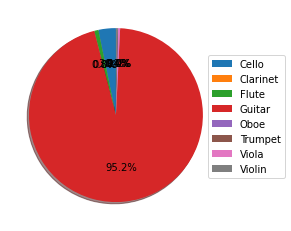

In [115]:
i = ['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin']
prob = np.array([3.2471e-02, 3.1499e-05, 7.6682e-03, 9.5205e-01, 5.2906e-06, 4.3995e-07,
        4.0501e-03, 3.7274e-03])*10
prob1 = np.array([6.2899e-06, 5.2807e-01, 1.8988e-01, 4.1750e-02, 1.8908e-01, 4.4705e-02,
        2.3946e-03, 4.1071e-03])*10
labels = i
sizes = prob
plt.pie(sizes, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(i, bbox_to_anchor=(0.9,0.8))

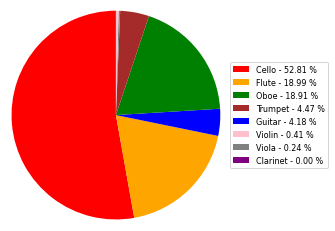

In [120]:
import matplotlib.pyplot as plt
import numpy as np
prob1 = np.array([ 5.2807e-01,6.2899e-06, 1.8988e-01, 4.1750e-02, 1.8908e-01, 4.4705e-02,
        2.3946e-03, 4.1071e-03])*10
x = i
y = prob1
colors = ['red','purple','orange','blue','green','brown','grey','pink']
porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center', bbox_to_anchor=(1.25,.5),
           fontsize=8)

plt.savefig('piechart.png', bbox_inches='tight')

In [110]:
import matplotlib.pyplot as plt
import numpy as np

x = i
y = [6.2899e-06, 5.2807e-01, 1.8988e-01, 4.1750e-02, 1.8908e-01, 4.4705e-02,
        2.3946e-03, 4.1071e-03]*100
colors = ['red','purple','orange','blue','green','brown','grey','pink']
porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center', bbox_to_anchor=(1.25,.5),
           fontsize=8)

plt.savefig('piechart.png', bbox_inches='tight')

TypeError: can't multiply sequence by non-int of type 'float'

In [26]:
def visualize(bs,lines):
    plt.figure(figsize = (8,6))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(1-bs, cmap = 'gray',origin='lower')
    for l in lines:
        plt.axhline(l,c='black')
    

In [27]:
def decodeColumn(num):
    col = []
    for i in range(31):
        col.insert(0,num%2)
        num = int(num/2)
    return col

1


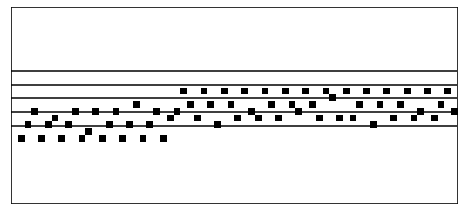

In [108]:
with open('/home/dyang/InstrumentID/bootleg_data-v1/labeled/cello/cello_120.bscore', 'rb') as f:
    data= pickle.load(f)
print(len(data))
for idx,page in enumerate(data):
    x = []
    for col in page:
        arr = decodeColumn(col)
        x.append(arr)
    x = np.array(x)
    x = x.T
    if idx == 0:
        visualize(x[2:,:66], [11, 13, 15, 17, 19])